<h2>Linear Programming Optimisation</h2><\br> 

<b>Rohit Kumar Tilwani, Sai Pramodh Sabarissan</b>

<h4>Problem Statement:</h4> For the given problem statement, we require to minimize the cost of electricity production while also ensuring that the supply meets the demand, that varies hourly over the period of 24 hours for a single day. The resources provided are ten generators with different configurations which can be tuned as per the demand.

<h4>Notations:</h4> Since demand and supply from generators depends on time, we define T as the set of integer values in [1, 24], denoting the hour of the day. Demand at any time t can be represented as Dt , where t ϵ T. Let H, SD, G, SLR be the sets of hydro, solid, gas, and solar generators respectively. Also, let Px,t denote the production of any generator x at time t, where t ϵ T.

In [1]:
# importing the required packages
import pandas as pd
from ortools.linear_solver import pywraplp
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [2]:
# reading all the given data
elec_demand = pd.read_csv("demand.csv", header = None)
gen_limits = pd.read_csv("generator_info.csv")
solar_out_ratio = pd.read_csv("solar_curve.csv", header = None)

In [3]:
# daclaring the solver instance
solver = pywraplp.Solver.CreateSolver("GLOP")

In [4]:
# getters for the demand and solar_factor for a particular hour
def get_demand(hour):
    return elec_demand.iloc[hour-1, 0]
def get_solar_out_factor(hour):
    return solar_out_ratio.iloc[hour-1, 0]

<h4>Constraints and Decision Variables:</h4> Apart from the lower and upper bound constraints of generators which are already given, we also have a constraint that at any time t ϵ T, supply from all generators should be equal to demand. Using the above notations, it can be defined as:

$\sum P_{h,t}\ \forall\ h \in H + \sum P_{s,t}\ \forall\ s\in SD + \sum P_{g,t}\ \forall\ g\in G + \sum P_{r,t}\ \forall\ r \in SLR=D_{t}\ \ \ \ \ ...\ eq(i)$

Another constraint we have is on three solid generators, either of which has production equal to the production of the previous hour. It can be written as: 
            

$P_{s,t} =P_{s,t-1}\ \forall\ s \in SD , \forall\ t \in T-\{1\}\ \ \ \ \ ...\ eq(ii)$ 

The decision variables for the problem are the productions of all of the generators in 24 hours as shown in eq(i). Hence the total number of decision variables is 24 * 10 = 240.
Below is the code for the addition of decision variables and then the constraints.

In [5]:
# adding the variable and returning the reference of the variable
def add_variable(solver, gen, name):
    lower, upper = float(gen["lower_bound (MW)"]), float(gen["upper_bound (MW)"])
    if gen["type"] == "solar":
        # changing upper limit of solar generator depending on the time hour
        upper = float(gen["upper_bound (MW)"]) * get_solar_out_factor(hour)
    exec(f"{name} = solver.NumVar(lower, upper, name)")
    return eval(f"{name}")

In [6]:
# adding variables for all generators for all hours
var_ref = defaultdict(list)  # storing the variable references for further use in grouping
for index, gen in gen_limits.iterrows():
    var_name_prefix = f"{gen['type']}_{gen['name']}"  # variable name prefix
    lower, upper = float(gen["lower_bound (MW)"]), float(gen["upper_bound (MW)"])
    
    # adding variables for 24 hours for the current generator
    for hour in range(1, 25):
        var_name = var_name_prefix + "_hr_" + str(hour)
        # keeping the returned reference in the var_ref
        var_ref[gen["type"]].append(add_variable(solver, gen, var_name))

In [7]:
# groubing of variables by their name, to be used while adding constraints
gen_vars_namewise = defaultdict(list)
for key, group in itertools.groupby(var_ref["hydro"] + var_ref["solid"] + var_ref["gas"] + var_ref["solar"], lambda x: str(x).split("_")[1][0]):
    gen_vars_namewise[key] = list(group)

In [8]:
# adding all constraints
for t in range(1, 25):
    demand = get_demand(t)
    var_index = t - 1
    production = sum([gen_vars_namewise[gen_name][var_index] for gen_name in "ABCDEFGHIJ"])
    cons_name = "cons_demand_" + str(t)
    solver.Add(production == demand, name = cons_name)
    if t < 24:
        for solid_gen_name in "EFG":
            cons_name = "cons_solid_" + str(solid_gen_name) + str(t)
            solver.Add(gen_vars_namewise[solid_gen_name][t] == gen_vars_namewise[solid_gen_name][t - 1], name = cons_name)

<h4>Objective Function:</h4> Objective is the minimization of the cost which is provided in EUR/MW. We define the total cost for the day as the production of generators multiplied by their corresponding cost information provided, as shown below.

$Cost,C= 1.4 *\sum P_{h,t}\ \forall\ h \in H,\forall\ t \in T \\\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ + 4.4 * \sum P_{s,t}\ \forall\ S \in SD, \forall\ t\in T \\\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ +9.1 *\sum P_{g,t}\ \forall\ g\in G, \forall\ t\in T \\\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ + 6.4 *\sum P_{r,t}\ \forall\ r \in SLR, \forall\ t\in T\ \ \ \ \ ...\ eq(iii)$

In [9]:
# defining Objective function as per the given cost
solver.Minimize(1.4 * sum(var_ref["hydro"])  
                + 4.4 * sum(var_ref["solid"])
                + 9.1 * sum(var_ref["gas"]) 
                + 6.4 * sum(var_ref["solar"]))

In [10]:
# running the optimisation
run_status = solver.Solve()

In [11]:
# printing out the values and variables
if run_status == pywraplp.Solver.OPTIMAL:
    print('Cost: ', solver.Objective().Value())
    #for var in solver.variables():
       # print(str(var), var.solution_value())

Cost:  151504.50000000003


<h4>Result:</h4> On solving the above equations using OR-tools in Python, the minimum cost incurred for maintaining the required supply along with the constraints is EUR 151504.5.

The activity and slack for each of the generator in every hour can be calculated as shown in the following piece of code.

In [12]:
result_df = pd.DataFrame(columns = ["type", "name", "hour", "var_name", "activity", "slack"])
for variable in solver.variables():
    name_split = variable.name().split("_")
    result_df.loc[len(result_df)] = [name_split[0], name_split[1], int(name_split[3]), variable.name(), variable.solution_value(), variable.ub() - variable.solution_value()]
    
result_df["binding"] = result_df["slack"].map(lambda x: x == 0)
result_df

,type,name,hour,var_name,activity,slack,binding
0,hydro,A,1,hydro_A_hr_1,69.0,31.0,False
1,hydro,A,2,hydro_A_hr_2,54.0,46.0,False
2,hydro,A,3,hydro_A_hr_3,54.0,46.0,False
3,hydro,A,4,hydro_A_hr_4,46.0,54.0,False
4,hydro,A,5,hydro_A_hr_5,33.0,67.0,False
...,...,...,...,...,...,...,...
235,solar,J,20,solar_J_hr_20,0.0,0.0,True
236,solar,J,21,solar_J_hr_21,0.0,0.0,True
237,solar,J,22,solar_J_hr_22,0.0,0.0,True
238,solar,J,23,solar_J_hr_23,0.0,0.0,True


<h4>Visualisation: </h4>
Since the cost is not effected by distribution of production within a certain category, for e.g. cost of 100 MW of hydro production is same irrespective of how much each hydro generator is producing, we can focus on variations within generator categories.

We use matplotlib to plot the aggregate production vs time for all generator classes except for solid (which is always taking the constant values) as shown below:

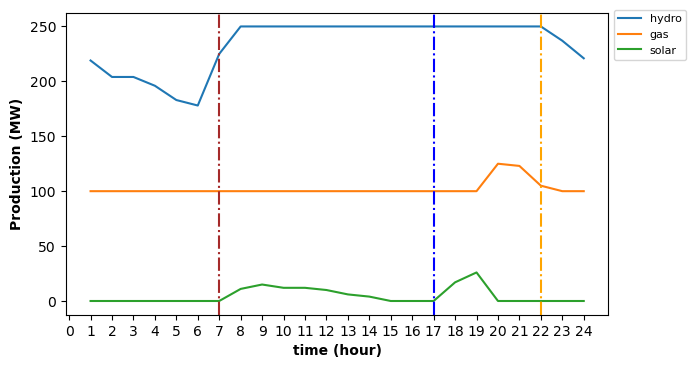

In [13]:
# visualising the aggregate result
figure(figsize=(7, 4), dpi = 100)
for t in result_df["type"].unique():
    if t == "solid":continue
    df = result_df[result_df["type"] == t].groupby("hour").agg("sum")
    plt.plot(list(df.index), df["activity"], label = t)
for v_line, color in zip([7, 17, 22], ["brown", "blue", "orange"]): plt.axvline(x = v_line, c = color, linestyle = "dashdot")
plt.legend(loc = "upper left", bbox_to_anchor = (1, 1.028),prop = {"size": 8})
plt.xlabel("time (hour)", fontdict = {"fontweight": "bold"});plt.ylabel("Production (MW)", fontdict = {"fontweight": "bold"})
t = plt.xticks(np.arange(0, 25, 1.0))

<h4>Analysis and Interpretation:</h4>It can be observed from the vertical lines at hour 7 and 17 that whenever the demand increases, priority is given to hydro production, since it is cheapest resource available, followed by solar and gas respectively. And also, on the same principle, hydro generator production is the last one to be decreased as can be see on hour = 22. The algorithm tries to fulfill demand using hydro, solar, gas in decreasing order of preference. It can also be seen that the hydro generators are the binding resources (slack = 0) from hour 8 to hour 22, as the production is equal to sum of upper bounds of all generators.

Hence, the upper bound constraints on hydro generators and lower bound constraint on gas generator turn out to be most important as they are directly influencing the cost. i.e. higher upper bound of hydro generators and lesser lower bound of gas generators will further minimize the production cost.